In [5]:
import numpy as np

DTYPE = np.complex128

def ket00():
    """Return |00> as a length‑4 complex column vector."""
    v = np.zeros(4, dtype=DTYPE)
    v[0] = 1.0
    return v

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n

# Example
psi = ket00()
assert np.isclose(np.linalg.norm(psi), 1.0)
print(psi)
print(normalize(psi))


[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [3]:
# 1‑qubit and 2‑qubit gate definitions (matrix form)
I2 = np.array([[1, 0], [0, 1]], dtype=DTYPE)
H  = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=DTYPE)

# CNOT with control = q0 (MSB), target = q1 (LSB) in basis |q0 q1>
CNOT_01 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
], dtype=DTYPE)

# Expand a 1‑qubit unitary U to a 2‑qubit operator acting on target qubit t in |q0 q1> order
# t = 0 applies to q0 (MSB); t = 1 applies to q1 (LSB)

def expand_1q(U: np.ndarray, t: int) -> np.ndarray:
    if t == 0:   # act on q0 (MSB)
        return np.kron(U, I2)
    elif t == 1: # act on q1 (LSB)
        return np.kron(I2, U)
    else:
        raise ValueError("target index must be 0 or 1")

# Apply a gate matrix to a state vector

def apply(U: np.ndarray, psi: np.ndarray) -> np.ndarray:
    return U @ psi

# Quick unit tests
assert np.allclose(H.conj().T @ H, I2)
assert np.allclose(CNOT_01.conj().T @ CNOT_01, np.eye(4))

In [ ]:
psi = ket00()                 # |00> = [1, 0, 0, 0]

U = expand_1q(H, t=0)  
print(U)       # H on q0 (MSB): H ⊗ I
psi_Hq0 = apply(U, psi)
print(psi_Hq0)


[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]

[[ 0.70710678+0.j  0.        +0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j  0.70710678+0.j]
 [ 0.70710678+0.j  0.        +0.j -0.70710678+0.j -0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j -0.        +0.j -0.70710678+0.j]]
[0.70710678+0.j 0.        +0.j 0.70710678+0.j 0.        +0.j]


In [11]:
psi = ket00()                 # |00>
U = expand_1q(H, t=1)         # H on q1 (LSB): I ⊗ H
psi_Hq1 = apply(U, psi)
print(psi_Hq1)


[0.70710678+0.j 0.70710678+0.j 0.        +0.j 0.        +0.j]


In [12]:
psi = ket00()
U = expand_1q(H, t=0)         # H on q0
psi = apply(U, psi)
psi = apply(CNOT_01, psi)     # CNOT(q0→q1)
print(psi)


[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [13]:
def bell_state() -> np.ndarray:
    psi = ket00()
    # H on q0 (MSB), then CNOT(control=q0, target=q1)
    psi = apply(expand_1q(H, t=0), psi)
    psi = apply(CNOT_01, psi)
    return normalize(psi)

psi_bell = bell_state()
print("Bell state vector:", np.round(psi_bell, 6))
# Expected amplitudes (up to a global phase): [1/√2, 0, 0, 1/√2]


Bell state vector: [0.707107+0.j 0.      +0.j 0.      +0.j 0.707107+0.j]


{'00': 4983, '01': 0, '10': 0, '11': 5017}


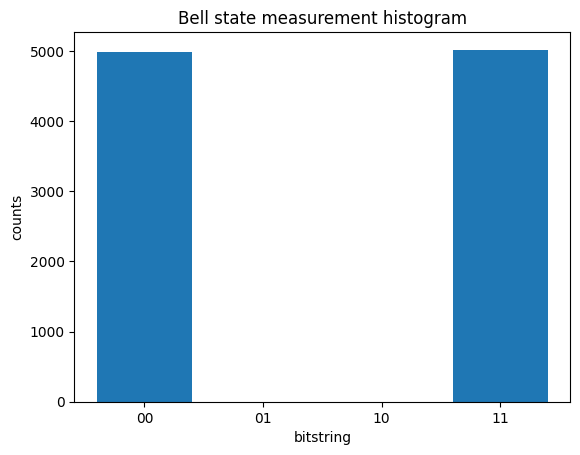

In [14]:
import matplotlib.pyplot as plt

BITSTR = ["00","01","10","11"]

def sample_bitstrings(psi: np.ndarray, shots: int = 10_000, seed: int = 7):
    rng = np.random.default_rng(seed)
    probs = np.abs(psi)**2
    idx = rng.choice(4, size=shots, p=probs)
    return idx

# Sample from Bell state
shots = 10_000
idx = sample_bitstrings(psi_bell, shots=shots)

# Make histogram
counts = {b: int(np.sum(idx == i)) for i, b in enumerate(BITSTR)}
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstring"); plt.ylabel("counts"); plt.title("Bell state measurement histogram")
plt.show()


In [16]:
# Empirical probabilities
p_emp = {b: c / shots for b, c in counts.items()}
print("Empirical probs:", p_emp)

# 95% CI (normal approx) for the nonzero outcomes
import math
def ci95(p, N):  # symmetric normal approx
    se = math.sqrt(p*(1-p)/N)
    return (p - 1.96*se, p + 1.96*se)

print("Expected: P(00)=0.5, P(11)=0.5, others=0")
print("95% CI around 0.5:", ci95(0.5, shots))


Empirical probs: {'00': 0.4983, '01': 0.0, '10': 0.0, '11': 0.5017}
Expected: P(00)=0.5, P(11)=0.5, others=0
95% CI around 0.5: (0.4902, 0.5098)


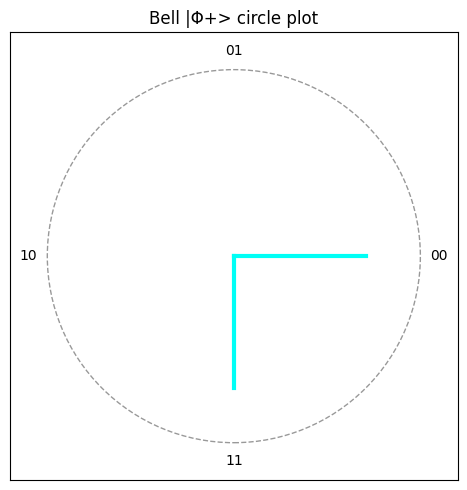

In [15]:
def circle_plot_state(psi: np.ndarray, labels=BITSTR, title="Circle notation (magnitude & phase)"):
    amps = psi.astype(complex)
    mags = np.abs(amps)
    phases = np.angle(amps)  # radians in [-pi, pi]

    # Place 4 basis states at fixed angles around the circle
    # (0, 90, 180, 270 deg). For n qubits, you’d use np.linspace.
    theta = np.linspace(0, 2*np.pi, len(amps), endpoint=False)

    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.set_aspect('equal')
    # Circle boundary
    circ = plt.Circle((0,0), 1.0, fill=False, ls='--', alpha=0.4)
    ax.add_artist(circ)

    # Rays for each amplitude
    for i, (r, ph, ang, lab) in enumerate(zip(mags, phases, theta, labels)):
        x = r * np.cos(ang)
        y = r * np.sin(ang)
        # Color encodes phase (hue via normalized angle)
        # map phase [-pi, pi] to [0,1]
        hue = (ph + np.pi) / (2*np.pi)
        color = plt.cm.hsv(hue)
        ax.plot([0, x], [0, y], lw=3, color=color)
        ax.text(1.1*np.cos(ang), 1.1*np.sin(ang), lab, ha='center', va='center')

    ax.set_xlim(-1.2, 1.2); ax.set_ylim(-1.2, 1.2)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    plt.tight_layout(); plt.show()

circle_plot_state(psi_bell, BITSTR, "Bell |Φ+> circle plot")


In [17]:
import numpy as np

DTYPE = np.complex128

# --- 1) Basics: |0>, |1>, H, projectors ---
ket0 = np.array([1,0], dtype=DTYPE)
ket1 = np.array([0,1], dtype=DTYPE)
I2   = np.eye(2, dtype=DTYPE)
H    = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=DTYPE)
P0   = np.array([[1,0],[0,0]], dtype=DTYPE)
P1   = np.array([[0,0],[0,1]], dtype=DTYPE)

def normalize(v):
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector")
    return v / n

# --- 2) Helpers: kron (left-to-right), expand_1q_n with MSB-first ---
def kron(*ops):
    out = np.array([1], dtype=DTYPE)
    for op in ops:
        out = np.kron(out, op)
    return out

def expand_1q_n(U: np.ndarray, t: int, n: int) -> np.ndarray:
    """
    Apply 1-qubit gate U to qubit index t in an n-qubit system,
    with MSB-first ordering: t=0 is MSB (leftmost), t=n-1 is LSB (rightmost).
    """
    ops = []
    for q in range(n):
        ops.append(U if q == t else I2)
    return kron(*ops)

# --- 3) SWAP between the last two qubits (A0,B0) in a 3-qubit system ---
# 2-qubit SWAP (on a pair): |00>,|01>,|10>,|11| -> swap middle two basis states
SWAP_2 = np.array([[1,0,0,0],
                   [0,0,1,0],
                   [0,1,0,0],
                   [0,0,0,1]], dtype=DTYPE)

# In 3 qubits (output, A0, B0) with MSB-first, SWAP(A0,B0) = I ⊗ SWAP_2
SWAP_A0_B0 = kron(I2, SWAP_2)  # shape (8,8)

# --- 4) SWAP test routine ---
def swap_test_fidelity(psi: np.ndarray, phi: np.ndarray, shots: int | None = None, seed: int = 7):
    """
    psi, phi: 1-qubit state vectors (need not be normalized; we normalize internally)
    Returns: F_hat (from output bit), F_exact (inner product), P1 (Pr(output=1))
    """
    # Normalize inputs
    psi = normalize(psi.astype(DTYPE))
    phi = normalize(phi.astype(DTYPE))

    # Initial 3-qubit state: |0>_out ⊗ |psi>_A ⊗ |phi>_B
    init = kron(ket0, psi, phi)  # length 8

    # H on output (t=0 in 3-qubit MSB-first), then controlled-SWAP via projector sum, then H on output
    U_Ho = expand_1q_n(H, t=0, n=3)  # shape (8,8)
    state = U_Ho @ init
    # Controlled-SWAP on (A0,B0) with control=output:
    # (|0><0| ⊗ I_4 + |1><1| ⊗ SWAP_2)
    U_cswap = kron(P0, np.eye(4, dtype=DTYPE)) + kron(P1, SWAP_A0_B0[2:2,0:0])  # not used; see next line
    # Since we already defined SWAP_A0_B0 as I⊗SWAP_2, directly use:
    state = (kron(P0, np.eye(4, dtype=DTYPE)) + kron(P1, SWAP_2)) @ state
    # Final H on output
    state = U_Ho @ state

    # Sanity: normalization
    assert np.isclose(np.sum(np.abs(state)**2), 1.0, atol=1e-12)

    # P1 = sum of probabilities where output bit = 1 (indices 4..7 in MSB-first)
    probs = np.abs(state)**2
    P1 = probs[4:].sum()
    F_hat = 1 - 2*P1

    # Exact fidelity
    F_exact = float(np.abs(np.vdot(psi, phi))**2)  # inputs already normalized

    # Optional: sample shots from output to estimate P1 empirically
    P1_emp = None
    if shots is not None:
        rng = np.random.default_rng(seed)
        # marginal prob of output=1 is P1; Bernoulli sampling:
        outs = rng.binomial(1, P1, size=shots)
        P1_emp = outs.mean()

    return F_hat, F_exact, P1, P1_emp

# --- 5) Test cases from the spec ---
psi0, psi1 = ket0, ket1
psi_plus   = normalize(H @ ket0)  # |+> = (|0>+|1>)/sqrt(2)

tests = [
    ("psi=phi (|0>,|0|)", psi0, psi0),
    ("orthogonal (|0>,|1|)", psi0, psi1),
    ("(|+>,|0|)", psi_plus, psi0),
]

for name, ps, ph in tests:
    F_hat, F_exact, P1, _ = swap_test_fidelity(ps, ph)
    print(f"{name:24s}  P1={P1:.4f}  F_hat={F_hat:.4f}  F_exact={F_exact:.4f}")


UnboundLocalError: cannot access local variable 'P1' where it is not associated with a value

In [1]:
import numpy as np

# ---------- Basics ----------
DTYPE = np.complex128

# |0>, |1>, I, H
ket0 = np.array([1, 0], dtype=DTYPE)
ket1 = np.array([0, 1], dtype=DTYPE)
I2   = np.eye(2, dtype=DTYPE)
H    = (1/np.sqrt(2)) * np.array([[1, 1],
                                  [1,-1]], dtype=DTYPE)

P0 = np.array([[1,0],[0,0]], dtype=DTYPE)  # |0><0|
P1 = np.array([[0,0],[0,1]], dtype=DTYPE)  # |1><1|

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n

def kron(*ops) -> np.ndarray:
    """Left-to-right Kronecker product."""
    out = np.array([1], dtype=DTYPE)
    for op in ops:
        out = np.kron(out, op)
    return out

# ---------- Gate expansion ----------
def expand_1q_n(U: np.ndarray, t: int, n: int) -> np.ndarray:
    """
    Expand a 1-qubit gate U to an n-qubit operator acting on qubit index t
    in MSB-first order (t=0 is MSB/leftmost, t=n-1 is LSB/rightmost).
    """
    ops = []
    for q in range(n):
        ops.append(U if q == t else I2)
    return kron(*ops)

# ---------- SWAP / CSWAP ----------
# 2-qubit SWAP on a pair: |00>,|01>,|10>,|11|  ->  |00>,|10>,|01>,|11|
SWAP_2 = np.array([[1,0,0,0],
                   [0,0,1,0],
                   [0,1,0,0],
                   [0,0,0,1]], dtype=DTYPE)

# For 3 qubits (output ⊗ A0 ⊗ B0) in MSB-first:
# CSWAP = (|0><0| ⊗ I_4) + (|1><1| ⊗ SWAP_2)
CSWAP = kron(P0, np.eye(4, dtype=DTYPE)) + kron(P1, SWAP_2)

# ---------- SWAP test routine ----------
def swap_test_fidelity(psi: np.ndarray, phi: np.ndarray):
    """
    Run SWAP test on 1-qubit states psi and phi.
    Returns: F_hat (from output qubit), F_exact (inner product), P1, final state vector.
    MSB-first ordering: output ⊗ A0 ⊗ B0.
    """
    # Normalize inputs
    psi = normalize(psi.astype(DTYPE))
    phi = normalize(phi.astype(DTYPE))

    # Initial 3-qubit state: |0>_out ⊗ |psi>_A ⊗ |phi>_B
    init = kron(ket0, psi, phi)  # length 8

    # H on output (t=0 in 3 qubits), then CSWAP, then H on output
    U_Ho = expand_1q_n(H, t=0, n=3)
    state = U_Ho @ init
    state = CSWAP @ state
    state = U_Ho @ state

    # Sanity: normalization
    assert np.isclose(np.sum(np.abs(state)**2), 1.0, atol=1e-12)

    # Probability that output = 1  (indices 4..7 because MSB-first)
    probs = np.abs(state)**2
    P1 = probs[4:].sum()

    # Fidelity estimate from SWAP test
    F_hat = 1 - 2*P1

    # Exact fidelity from inner product
    F_exact = float(np.abs(np.vdot(psi, phi))**2)

    return F_hat, F_exact, float(P1), state

# ---------- Test cases ----------
psi0 = ket0
psi1 = ket1
psi_plus = normalize(H @ ket0)  # |+> = (|0>+|1>)/sqrt(2)

tests = [
    ("Identical: |0> vs |0>", psi0, psi0,   "theory: F=1, P1=0"),
    ("Orthogonal: |0> vs |1>", psi0, psi1, "theory: F=0, P1=1/2"),
    ("Overlap: |+> vs |0>",    psi_plus, psi0, "theory: F=1/2, P1=1/4"),
]

for name, ps, ph, theory in tests:
    F_hat, F_exact, P1, _ = swap_test_fidelity(ps, ph)
    print(f"{name:24s}  {theory:>24s}  ->  P1={P1:.4f}  F_hat={F_hat:.4f}  F_exact={F_exact:.4f}")


Identical: |0> vs |0>            theory: F=1, P1=0  ->  P1=0.0000  F_hat=1.0000  F_exact=1.0000
Orthogonal: |0> vs |1>         theory: F=0, P1=1/2  ->  P1=0.5000  F_hat=0.0000  F_exact=0.0000
Overlap: |+> vs |0>          theory: F=1/2, P1=1/4  ->  P1=0.2500  F_hat=0.5000  F_exact=0.5000


In [2]:
import numpy as np

# ---------- Basics ----------
DTYPE = np.complex128

# |0>, |1>, I, H
ket0 = np.array([1, 0], dtype=DTYPE)
ket1 = np.array([0, 1], dtype=DTYPE)
I2   = np.eye(2, dtype=DTYPE)
H    = (1/np.sqrt(2)) * np.array([[1, 1],
                                  [1,-1]], dtype=DTYPE)

P0 = np.array([[1,0],[0,0]], dtype=DTYPE)  # |0><0|
P1 = np.array([[0,0],[0,1]], dtype=DTYPE)  # |1><1|

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n

def kron(*ops) -> np.ndarray:
    """Left-to-right Kronecker product."""
    out = np.array([1], dtype=DTYPE)
    for op in ops:
        out = np.kron(out, op)
    return out

# ---------- Gate expansion ----------
def expand_1q_n(U: np.ndarray, t: int, n: int) -> np.ndarray:
    """
    Expand a 1-qubit gate U to an n-qubit operator acting on qubit index t
    in MSB-first order (t=0 is MSB/leftmost, t=n-1 is LSB/rightmost).
    """
    ops = []
    for q in range(n):
        ops.append(U if q == t else I2)
    return kron(*ops)

# ---------- SWAP / CSWAP ----------
# 2-qubit SWAP on a pair: |00>,|01>,|10>,|11| -> |00>,|10>,|01>,|11|
SWAP_2 = np.array([[1,0,0,0],
                   [0,0,1,0],
                   [0,1,0,0],
                   [0,0,0,1]], dtype=DTYPE)

# For 3 qubits (output ⊗ A0 ⊗ B0) in MSB-first:
# CSWAP = (|0><0| ⊗ I_4) + (|1><1| ⊗ SWAP_2)
CSWAP = kron(P0, np.eye(4, dtype=DTYPE)) + kron(P1, SWAP_2)

# ---------- SWAP test routine ----------
def swap_test_fidelity(psi: np.ndarray, phi: np.ndarray):
    """
    Run SWAP test on 1-qubit states psi and phi.
    Returns: F_hat (from output qubit), F_exact (inner product), P1, final 8-dim state.
    MSB-first ordering: output ⊗ A0 ⊗ B0.
    """
    # Normalize inputs
    psi = normalize(psi.astype(DTYPE))
    phi = normalize(phi.astype(DTYPE))

    # Initial 3-qubit state: |0>_out ⊗ |psi>_A ⊗ |phi>_B
    init = kron(ket0, psi, phi)  # length 8

    # H on output (t=0 in 3 qubits), then CSWAP, then H on output
    U_Ho = expand_1q_n(H, t=0, n=3)
    state = U_Ho @ init
    state = CSWAP @ state
    state = U_Ho @ state

    # Sanity: normalization
    assert np.isclose(np.sum(np.abs(state)**2), 1.0, atol=1e-12)

    # Probability that output = 1  (indices 4..7 because MSB-first)
    probs = np.abs(state)**2
    P1 = float(probs[4:].sum())

    # Fidelity estimate from SWAP test
    F_hat = float(1 - 2*P1)

    # Exact fidelity from inner product
    F_exact = float(np.abs(np.vdot(psi, phi))**2)

    return F_hat, F_exact, P1, state

# ---------- Example test cases ----------
psi0 = ket0
psi1 = ket1
psi_plus = normalize(H @ ket0)  # |+> = (|0>+|1>)/sqrt(2)

tests = [
    ("Identical: |0> vs |0>", psi0, psi0,   "theory: F=1,   P1=0"),
    ("Orthogonal: |0> vs |1>", psi0, psi1, "theory: F=0,   P1=1/2"),
    ("Overlap: |+> vs |0>",    psi_plus, psi0, "theory: F=1/2, P1=1/4"),
]

for name, ps, ph, theory in tests:
    F_hat, F_exact, P1, _ = swap_test_fidelity(ps, ph)
    print(f"{name:24s}  {theory:>20s}  ->  P1={P1:.6f}  F_hat={F_hat:.6f}  F_exact={F_exact:.6f}")


Identical: |0> vs |0>      theory: F=1,   P1=0  ->  P1=0.000000  F_hat=1.000000  F_exact=1.000000
Orthogonal: |0> vs |1>    theory: F=0,   P1=1/2  ->  P1=0.500000  F_hat=0.000000  F_exact=0.000000
Overlap: |+> vs |0>       theory: F=1/2, P1=1/4  ->  P1=0.250000  F_hat=0.500000  F_exact=0.500000
